In [ ]:
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt

zip_path = 'Waveforms.zip'
extraction_path = 'waveforms'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)
pickings_path = 'Manual_pickings.csv'
pickings_df = pd.read_csv(pickings_path)
pickings_df = pickings_df.head(10000)
pickings_df.head()

,Waveform ID,P-wave arrrival relative to trigger time (microsecond)
0,1,-0.7
1,2,0.7
2,3,-1.8
3,4,2.4
4,5,-0.4


In [ ]:
waveforms_dir = os.path.join(extraction_path, 'Waveforms')
signal_files = sorted(os.listdir(waveforms_dir))

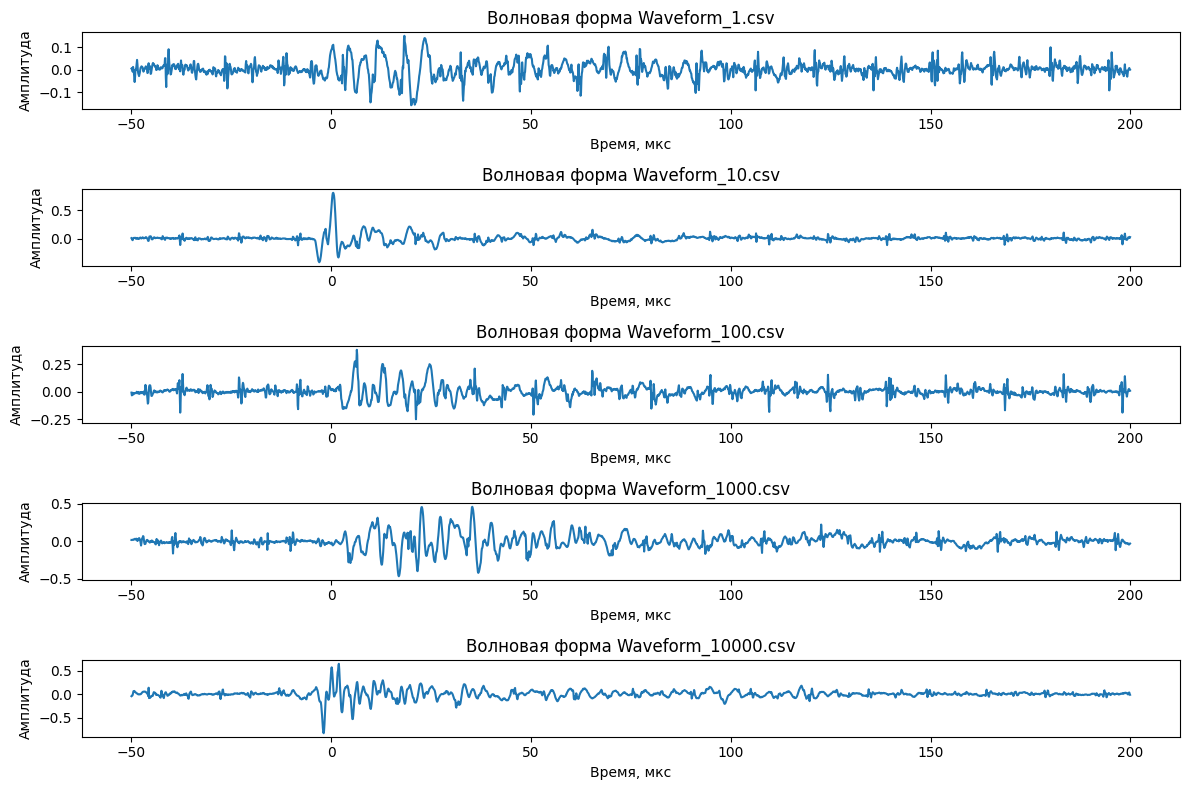

In [ ]:
def load_waveform(file_path):
    return np.loadtxt(file_path, skiprows=1, delimiter=',')

plt.figure(figsize=(12, 8))

for i, signal_file in enumerate(signal_files[:5]):
    signal_path = os.path.join(waveforms_dir, signal_file)
    signal = load_waveform(signal_path)
    plt.subplot(5, 1, i+1)
    plt.plot(signal[:, 0], signal[:, 1])
    plt.title(f'Волновая форма {signal_file}')
    plt.xlabel('Время, мкс')
    plt.ylabel('Амплитуда')

plt.tight_layout()
plt.show()


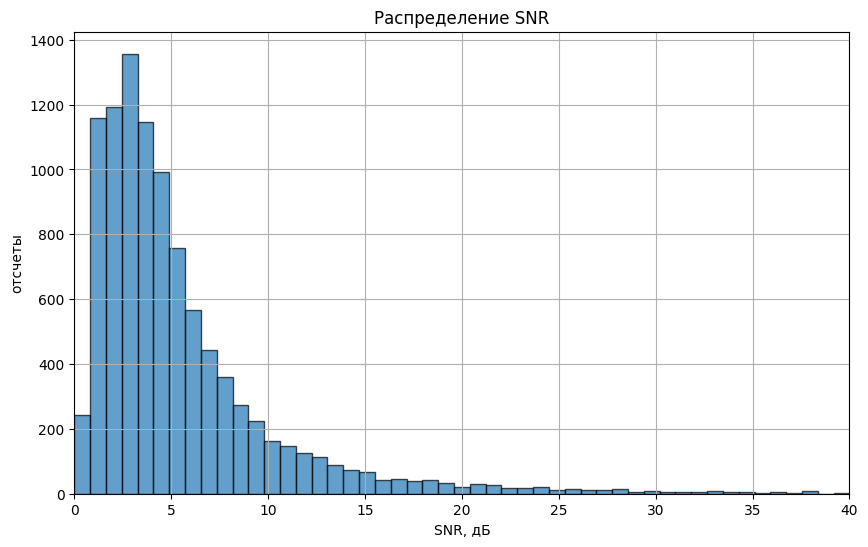

In [ ]:
def calculate_snr_sigma_ratio(signal, arrival_idx, window_samples=400):

    N = len(signal)
    startB = arrival_idx - window_samples
    endB   = arrival_idx
    if startB < 0:
        startB = 0
    segB = signal[startB:endB]
    sigmaB = np.std(segB)

    startA = arrival_idx
    endA   = arrival_idx + window_samples
    if startA > N:
        startA = N
    if endA > N:
        endA = N
    segA = signal[startA:endA]
    sigmaA = np.std(segA)

    if sigmaB < 1e-12:
        return np.nan

    snr_ratio = sigmaA / sigmaB
    return snr_ratio

snr_values = []

for i, signal_file in enumerate(signal_files):
    signal_path = os.path.join(waveforms_dir, signal_file)
    data = load_waveform(signal_path)
    time_axis = data[:, 0]   # мкс
    signal    = data[:, 1]   # амплитуда
    arrival_time = pickings_df.iloc[i, 1]  # P-wave arrival time (в мкс)
# Поиск индекса прихода
    arrival_idx = np.argmin(np.abs(time_axis - arrival_time))
# вычисляем SNR = sigmaA / sigmaB
    snr = calculate_snr_sigma_ratio(signal, arrival_idx)
    snr_values.append(snr)

bins = np.linspace(0, 40, 50)

plt.figure(figsize=(10, 6))
plt.hist(snr_values, bins=bins, edgecolor='k', alpha=0.7)
plt.xlim(0, 40)
plt.xlabel('SNR, дБ')
plt.ylabel('отсчеты')
plt.title(f'Распределение SNR')
plt.grid(True)
plt.show()

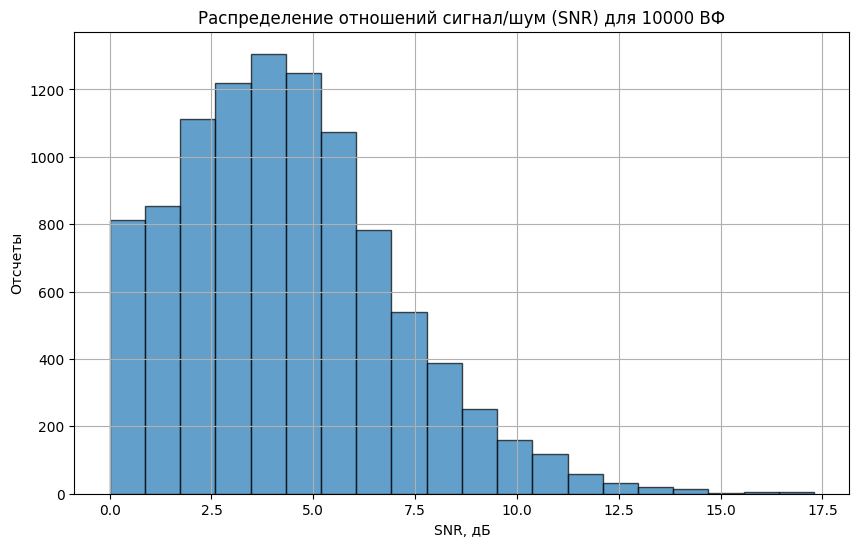

In [ ]:
# Функция для расчёта соотношения сигнал/шум (SNR)
def calculate_snr(signal, arrival_idx, pre_event_samples=100):
    signal_energy = np.std(signal[arrival_idx:])
    noise_energy = np.std(signal[max(arrival_idx-pre_event_samples, 0):arrival_idx])
    return np.abs(10 * np.log10(signal_energy / noise_energy))
    #return np.abs(np.log10(signal_energy / noise_energy))
snr_values = []

for i, signal_file in enumerate(signal_files):
    signal_path = os.path.join(waveforms_dir, signal_file)
    signal = load_waveform(signal_path)[:, 1]
    arrival_time = pickings_df.iloc[i, 1]  # в микросекундах
    time_axis = load_waveform(signal_path)[:, 0]
    arrival_idx = np.argmin(np.abs(time_axis - arrival_time))

    snr = calculate_snr(signal, arrival_idx)
    snr_values.append(snr)

plt.figure(figsize=(10, 6))
plt.hist(snr_values, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('SNR, дБ')
plt.ylabel('Отсчеты')
plt.title(f'Распределение отношений сигнал/шум (SNR) для {len(snr_values)} ВФ')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


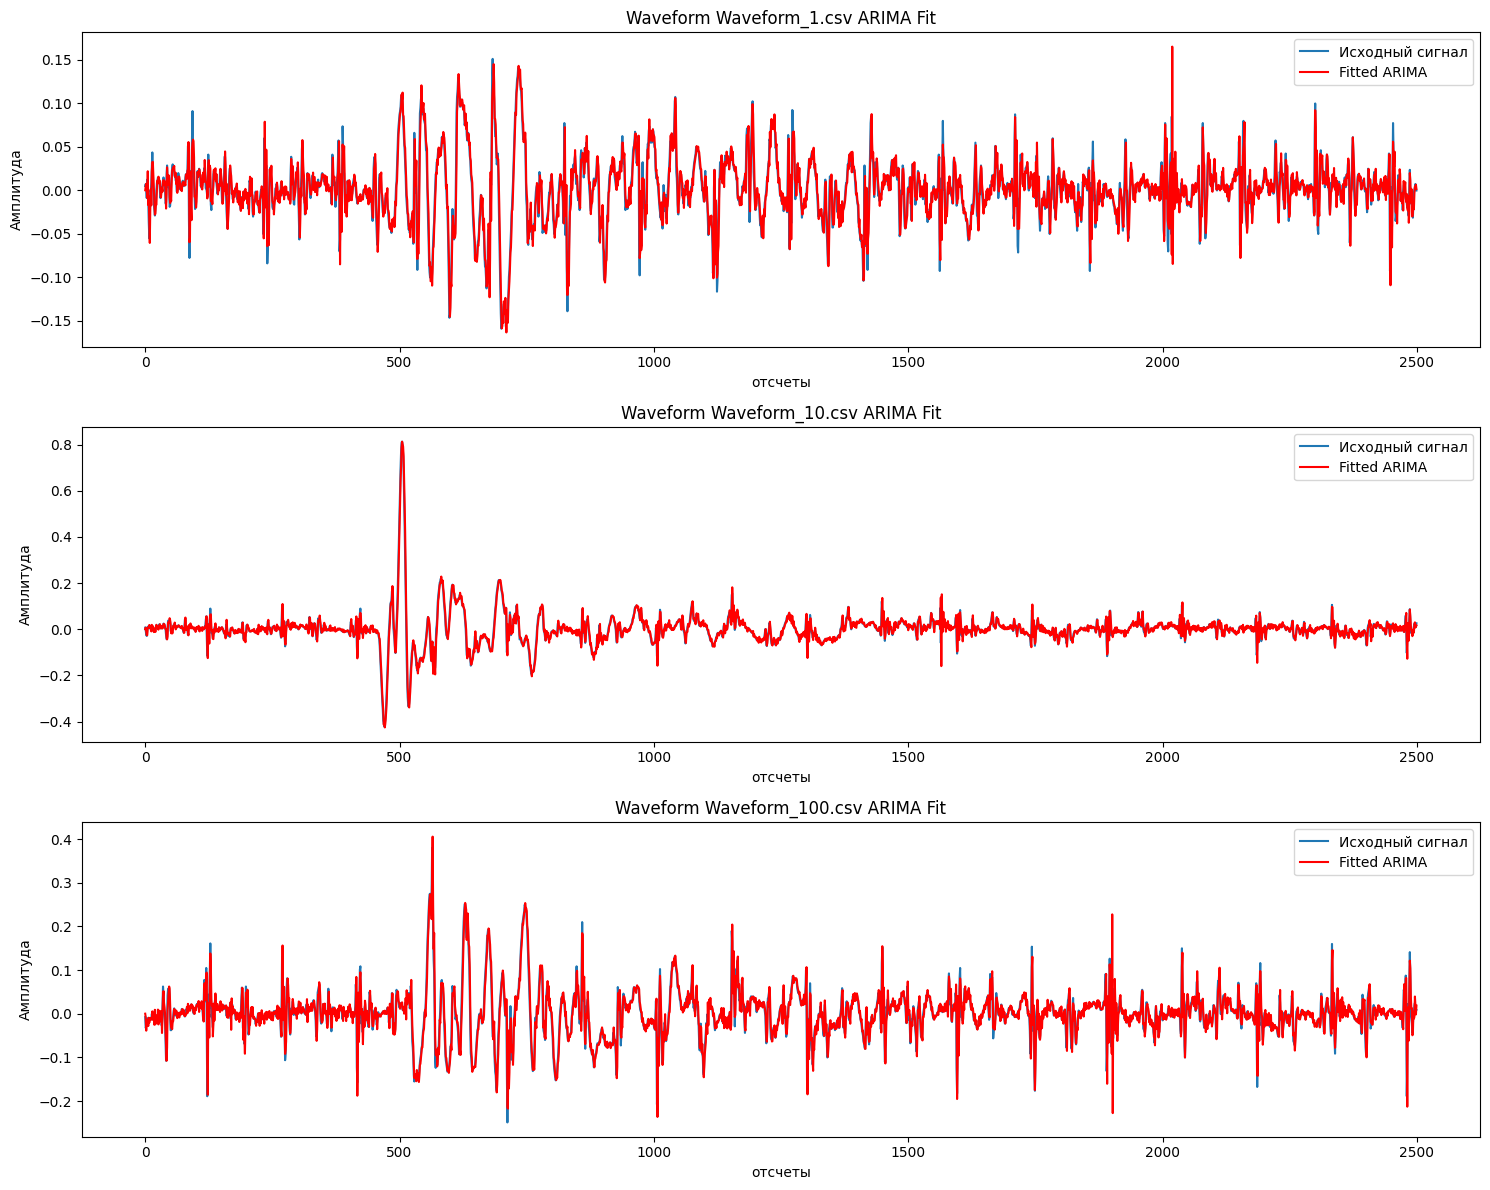

In [ ]:
import statsmodels.api as sm

plt.figure(figsize=(15, 12))

for i, signal_file in enumerate(signal_files[:3]):
    signal_path = os.path.join(waveforms_dir, signal_file)
    signal = load_waveform(signal_path)[:, 1]
    model = sm.tsa.ARIMA(signal, order=(2, 1, 2))
    results = model.fit()

    plt.subplot(3, 1, i+1)
    plt.plot(signal, label='Исходный сигнал')
    plt.plot(results.fittedvalues, color='red', label='Fitted ARIMA')
    plt.title(f'Waveform {signal_file} ARIMA Fit')
    plt.xlabel('отсчеты')
    plt.ylabel('Амплитуда')
    plt.legend()

plt.tight_layout()
plt.show()


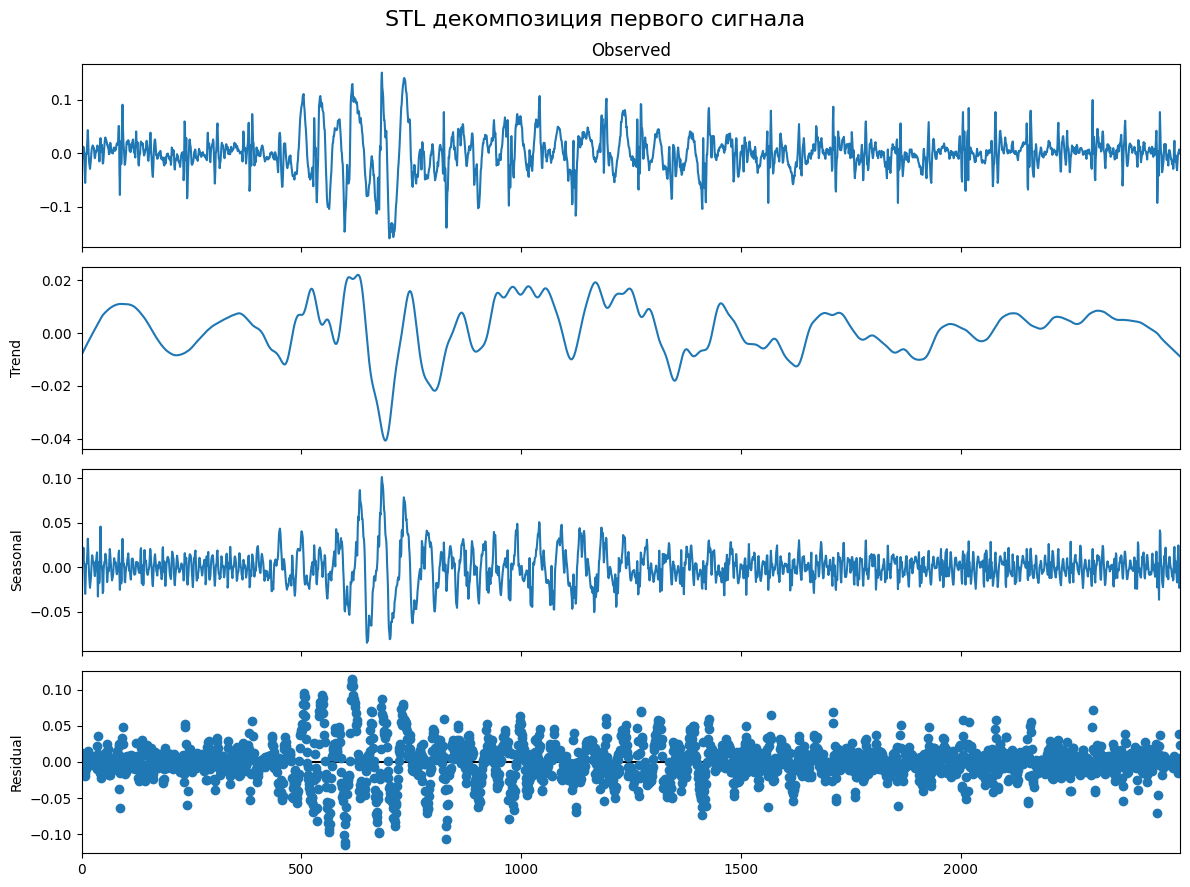

In [ ]:
from statsmodels.tsa.seasonal import STL

signal_path = os.path.join(waveforms_dir, signal_files[0])
signal_data = load_waveform(signal_path)
signal_time = signal_data[:, 0]
signal_amplitude = signal_data[:, 1]
stl = STL(signal_amplitude, period=50)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(12, 9)
fig.suptitle('STL декомпозиция первого сигнала', fontsize=16)

plt.tight_layout()
plt.show()


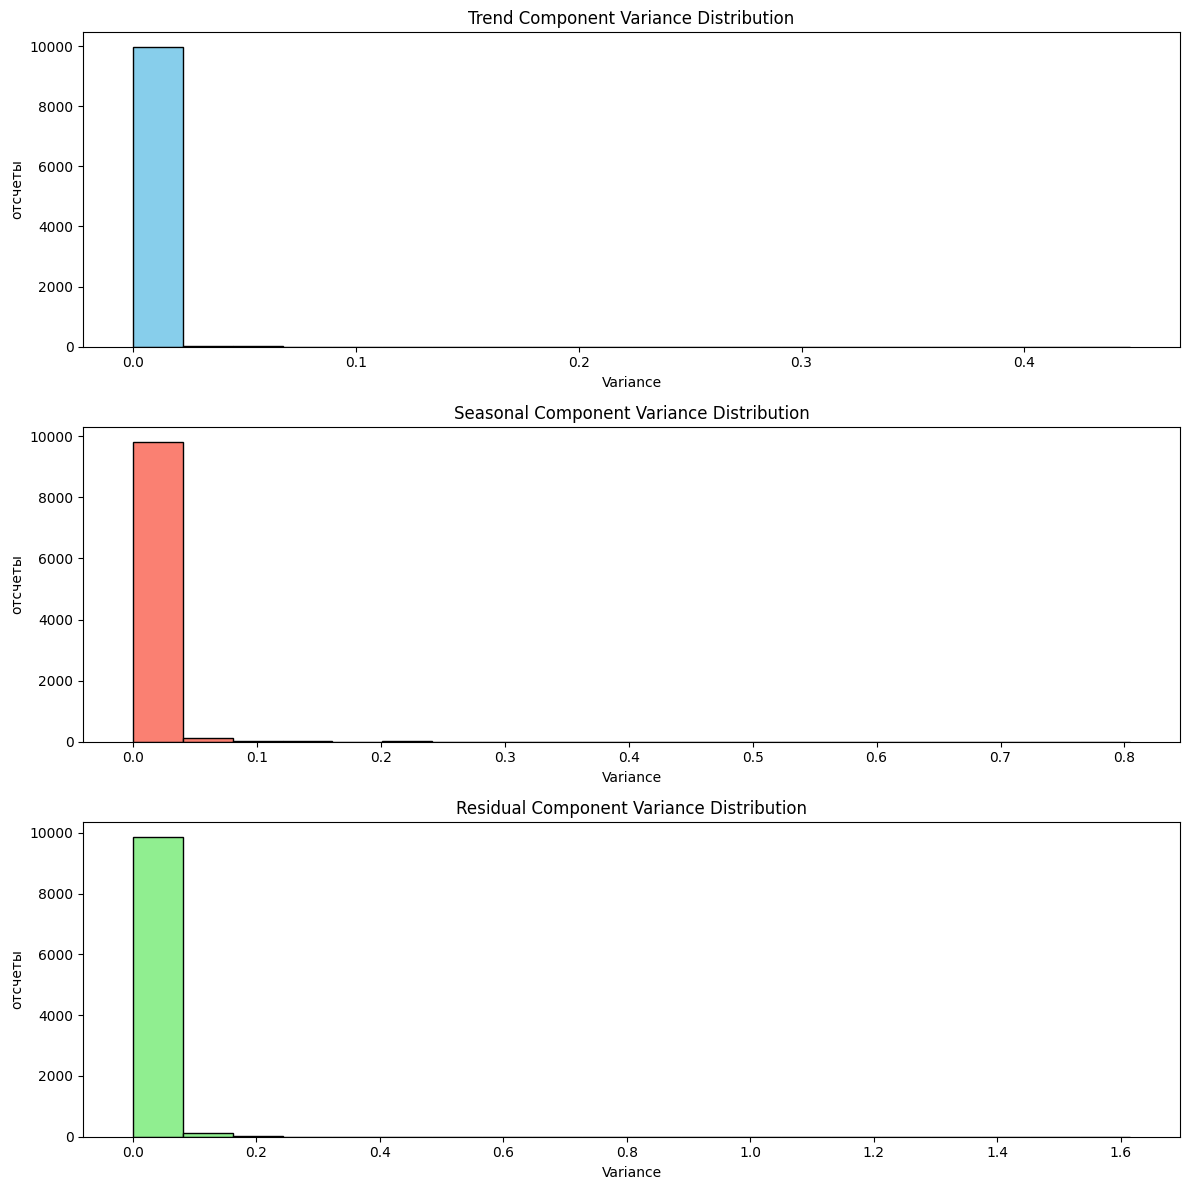

In [ ]:
trend_variances = []
seasonal_variances = []
residual_variances = []

for signal_file in signal_files:
    signal_path = os.path.join(waveforms_dir, signal_file)
    signal = load_waveform(signal_path)[:, 1]

    stl = STL(signal, period=50)  # период подобран для примера
    result = stl.fit()
    trend_variances.append(np.var(result.trend))
    seasonal_variances.append(np.var(result.seasonal))
    residual_variances.append(np.var(result.resid))

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

axes[0].hist(trend_variances, bins=20, color='skyblue', edgecolor='k')
axes[0].set_title('Trend Component Variance Distribution')
axes[0].set_xlabel('Variance')
axes[0].set_ylabel('отсчеты')

axes[1].hist(seasonal_variances, bins=20, color='salmon', edgecolor='k')
axes[1].set_title('Seasonal Component Variance Distribution')
axes[1].set_xlabel('Variance')
axes[1].set_ylabel('отсчеты')

axes[2].hist(residual_variances, bins=20, color='lightgreen', edgecolor='k')
axes[2].set_title('Residual Component Variance Distribution')
axes[2].set_xlabel('Variance')
axes[2].set_ylabel('отсчеты')

plt.tight_layout()
plt.show()


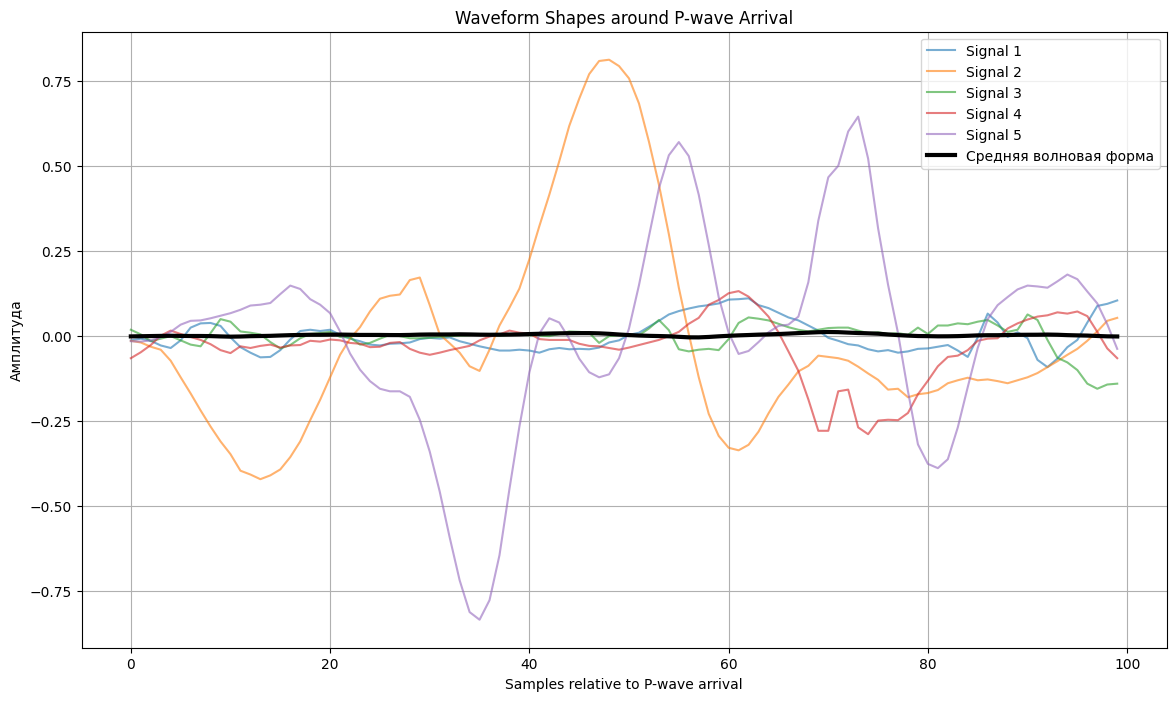

In [ ]:
window_size = 50
aligned_waveforms = []

for i, signal_file in enumerate(signal_files):  # Проанализируем первые 1000 сигналов
    signal_path = os.path.join(waveforms_dir, signal_file)
    signal_data = load_waveform(signal_path)
    signal = signal_data[:, 1]
    time_axis = signal_data[:, 0]
    arrival_time = pickings_df.iloc[i, 1]
    arrival_idx = np.argmin(np.abs(time_axis - arrival_time))
    start_idx = max(arrival_idx - window_size, 0)
    end_idx = min(arrival_idx + window_size, len(signal))
    segment = signal[start_idx:end_idx]

    # Проверка на размер сегмента, чтобы он был одинаковым у всех сигналов
    if len(segment) == 2 * window_size:
        aligned_waveforms.append(segment)

aligned_waveforms = np.array(aligned_waveforms)
average_waveform = np.mean(aligned_waveforms, axis=0)

plt.figure(figsize=(14, 8))
for i in range(5):
    plt.plot(aligned_waveforms[i], alpha=0.6, label=f'Signal {i+1}')

plt.plot(average_waveform, color='black', linewidth=3, label='Средняя волновая форма')
plt.title('Waveform Shapes around P-wave Arrival')
plt.xlabel('Samples relative to P-wave arrival')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)
plt.show()


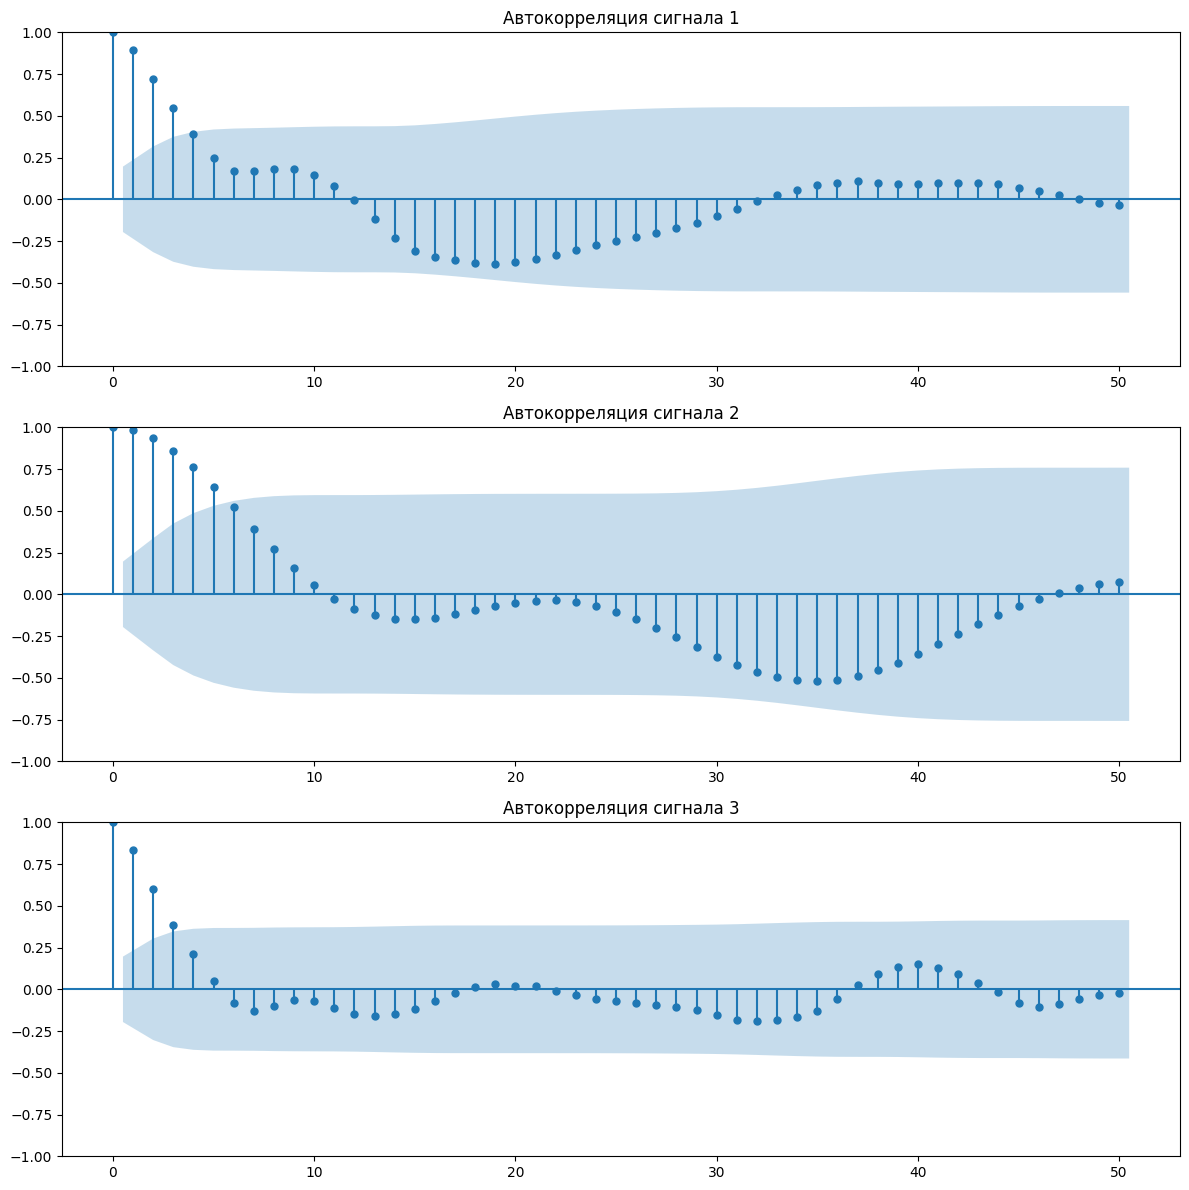

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Визуализация автокорреляции для первых 3 сигналов
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

for i in range(3):
    signal = aligned_waveforms[i]
    plot_acf(signal, lags=50, ax=axes[i])
    axes[i].set_title(f'Автокорреляция сигнала {i+1}')

plt.tight_layout()
plt.show()


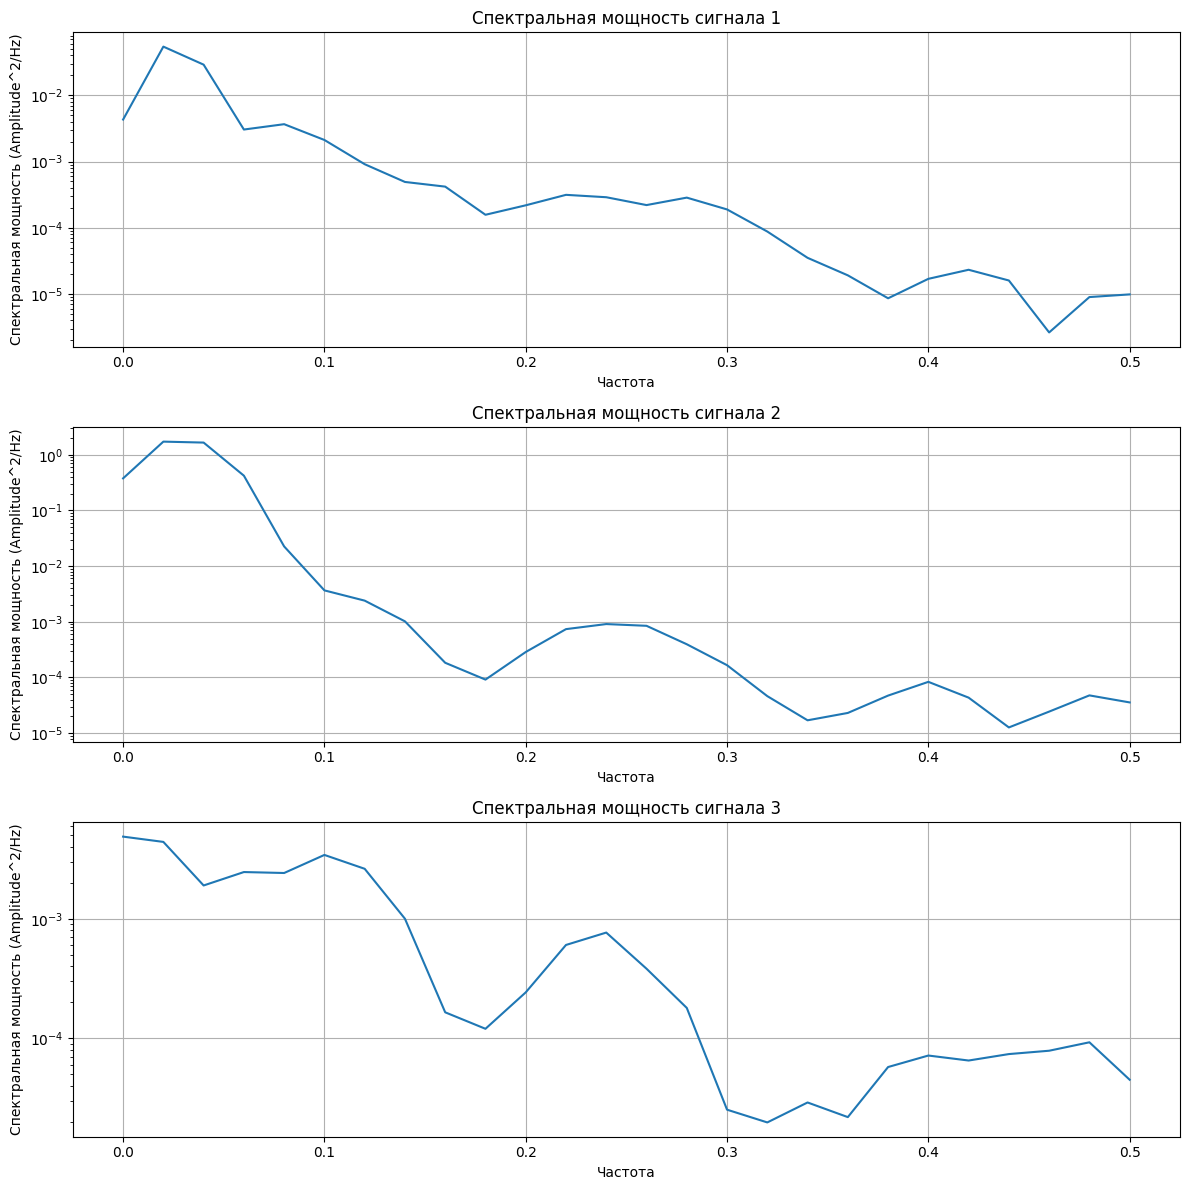

In [ ]:
from scipy.signal import welch

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

for i in range(3):
    signal = aligned_waveforms[i]

    freq, psd = welch(signal, fs=1.0, nperseg=50)

    axes[i].semilogy(freq, psd)
    axes[i].set_xlabel('Частота')
    axes[i].set_ylabel('Спектральная мощность (Amplitude^2/Hz)')
    axes[i].set_title(f'Спектральная мощность сигнала {i+1}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


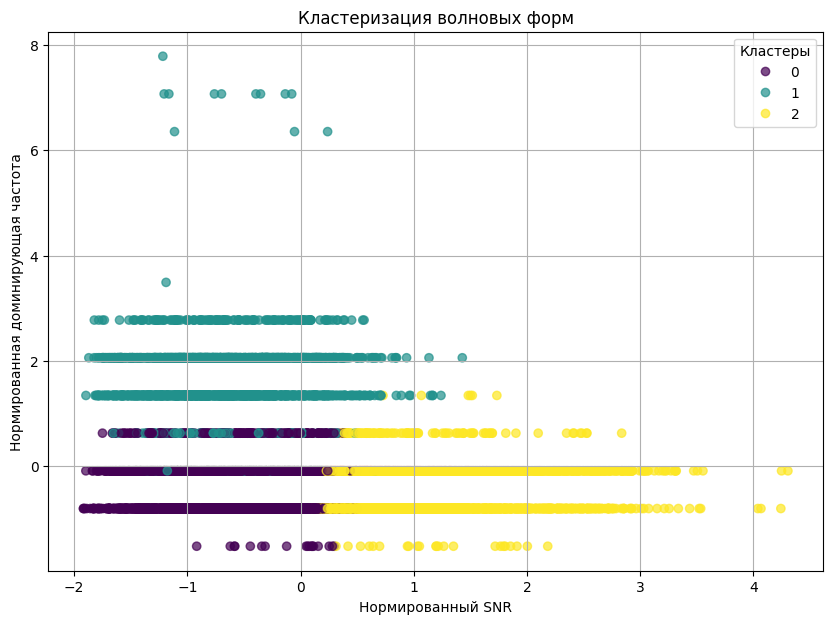

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def calculate_snr(signal):
    signal_energy = np.mean(signal**2)
    noise_energy = np.mean(signal[:10]**2)  # шум оцениваем по первым 10 отсчетам
    return 10 * np.log10(signal_energy / noise_energy)

features = []

for signal in aligned_waveforms:
    snr = calculate_snr(signal)
    freq, psd = welch(signal, fs=1.0, nperseg=50)
    dominant_freq = freq[np.argmax(psd)]
    mean_freq = np.sum(freq * psd) / np.sum(psd)
    features.append([snr, dominant_freq, mean_freq])

features = np.array(features)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel('Нормированный SNR')
plt.ylabel('Нормированная доминирующая частота')
plt.title('Кластеризация волновых форм')
plt.legend(*scatter.legend_elements(), title="Кластеры")
plt.grid(True)
plt.show()


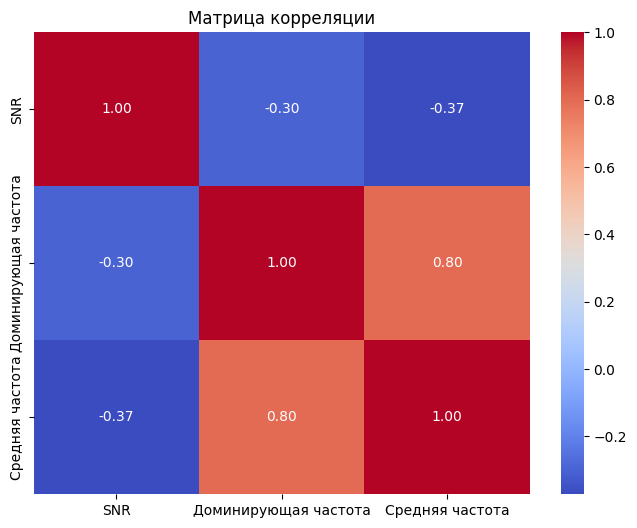

In [ ]:
import seaborn as sns

features_df = pd.DataFrame(features, columns=['SNR', 'Доминирующая частота', 'Средняя частота'])

corr_matrix = features_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции')
plt.show()


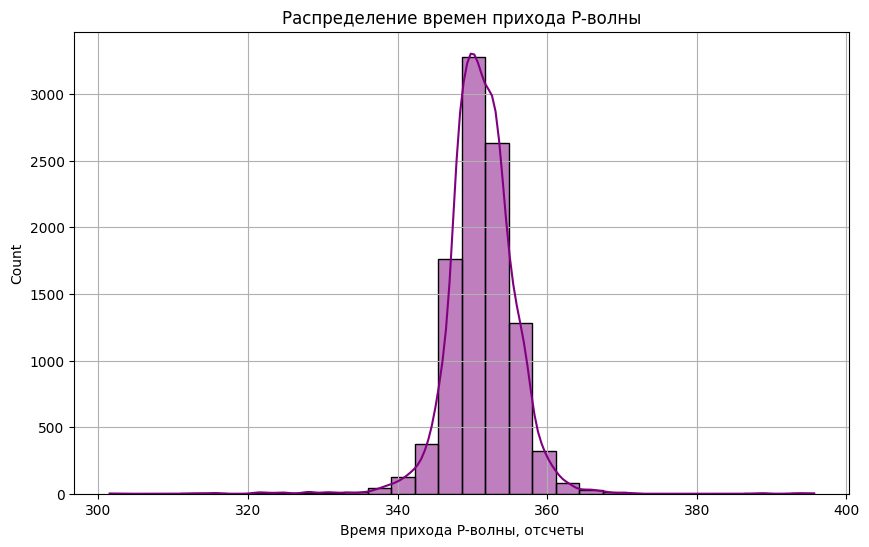

,P-wave arrrival relative to trigger time (microsecond)
count,10000.000000
mean,351.244510
std,4.471749
min,301.500000
25%,348.700000
50%,351.100000
75%,353.700000
max,395.700000


In [ ]:
arrival_times = pickings_df.iloc[:, 1] + 350

plt.figure(figsize=(10, 6))
sns.histplot(arrival_times, bins=30, kde=True, color='purple')
plt.xlabel('Время прихода P-волны, отсчеты')
#plt.ylabel('отсчеты')
plt.title('Распределение времен прихода P-волны')
plt.grid(True)
plt.show()

arrival_stats = arrival_times.describe()
arrival_stats
